<a href="https://colab.research.google.com/github/michaeljf00/text_summarizer/blob/roham/BBCDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !unzip data.zip

In [ ]:
pip install sumy numpy pandas nltk tensorflow matplotlib 

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random

## BBC News Summary EDA

### Data preparation
To get started please paste the BBC news dataset into a folder titled data in the local directory. Then delete 199.txt in the articles and summaries directory respectively due to corruption with these files.

In [8]:
def get_text_by_topic(directory_path):
    data = []
    count = 0
    for topic in os.listdir(directory_path):
        topic_path = os.path.join(directory_path, topic)
        if not os.path.isdir(topic_path):
          continue
        for file_path in os.listdir(topic_path):
            try:
                with open(f'{topic_path}/{file_path}', 'r', encoding="utf-8") as f:
                    data.append(( topic_path.split('/')[-1],f.read()))
                count+=1
            except UnicodeDecodeError:
                print(f'file {file_path} in {topic_path} is not readable')
                print(UnicodeDecodeError)
    df = pd.DataFrame(data, columns=['label','text'])
    print(f"Total Items loaded: {count}")
    return df
                      
articles_path = r"data/BBC News Summary/News Articles"
summaries_path = r"data/BBC News Summary/Summaries"

articles_df = get_text_by_topic(articles_path)
summaries_df = get_text_by_topic(summaries_path)
articles_df.head()

file .DS_Store in data/BBC News Summary/News Articles/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224
file .DS_Store in data/BBC News Summary/Summaries/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224


,label,text
0,tech,Finding new homes for old phones\n\nRe-using o...
1,tech,"Yahoo celebrates a decade online\n\nYahoo, one..."
2,tech,Web logs aid disaster recovery\n\nSome of the ...
3,tech,More movies head to Sony's PSP\n\nMovies Open ...
4,tech,Sony PSP tipped as a 'must-have'\n\nSony's Pla...


### Lets see an example from the dataset

In [9]:
print("Articles Shape: ",articles_df.shape)
print("Summaries Shape: ",summaries_df.shape)
# If this fails the wrong number of aricles or summaries was loaded
assert(articles_df.shape == summaries_df.shape)

ex_idx = int(random.random()*articles_df.shape[0])
ex_topic = articles_df["label"][ex_idx]
print(f"\nRandom Example Article in {ex_topic}:")
print(articles_df["text"][ex_idx])
print(f"Random Example Summary in {ex_topic}:")
print(summaries_df["text"][ex_idx])

Articles Shape:  (2224, 2)
Summaries Shape:  (2224, 2)

Random Example Article in politics:
Voters 'reject EU by two to one'

British voters would reject the European constitution by two to one, according to a poll posing the question the government will put to the country.

The Daily Telegraph poll suggests that 45% of people would vote against the constitution and 24% in favour. However the YouGov poll, which questioned 1,943 British adults online, found 25% did not know how they would vote if forced to decide tomorrow. Only 51% of those polled had made up their minds about the constitution. Another 7% said they would not vote at all. The poll is believed to be the first to pose the question which the government has chosen for the upcoming referendum, expected in 2006. The constitution will be incorporated into UK law if there is a yes vote.

Ballot papers in the poll will ask: "Should the United Kingdom approve the treaty establishing a constitution for the European Union?" The gove

From this example we can see the dataset consists of BBC articles and co-responding summaries that are constructed in an extractive manner, that is, each summary is constructed by selecting a subset of the sentances in the original article.

In [10]:
# Null Checks
articles_df.isna().sum()
summaries_df.isna().sum()

label    0
text     0
dtype: int64

Next looking into the balance of each topic in the dataset

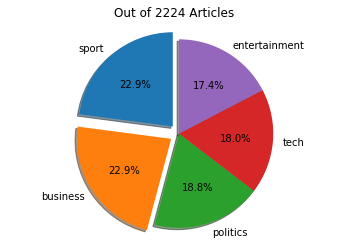

In [11]:
# Percent articles in each topic
label_vals = articles_df["label"].value_counts()

labels = list(label_vals.keys())
sizes = list(label_vals)
explode = [0]*len(sizes) 
explode[0] =0.1
explode[1] =0.1
fig1, ax1 = plt.subplots()
ax1.pie(label_vals, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Out of {articles_df.shape[0]} Articles")
plt.show()


The classes appear to be well balance so model performance should be equivelent across topics

99th percentile in sentance count:  63.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


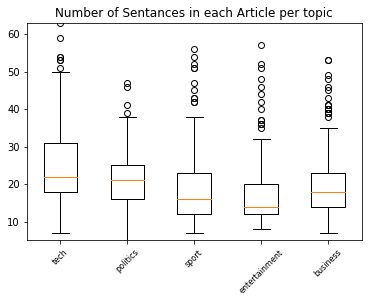

,tech,politics,sport,entertainment,business
count,401.000000,417.000000,510.000000,386.000000,510.000000
mean,25.842893,22.227818,18.280392,17.945596,19.680392
std,12.904370,15.467658,9.876736,14.270836,7.409560
min,7.000000,5.000000,7.000000,8.000000,7.000000
25%,18.000000,16.000000,12.000000,12.000000,14.000000
50%,22.000000,21.000000,16.000000,14.000000,18.000000
75%,31.000000,25.000000,23.000000,20.000000,23.000000
max,161.000000,246.000000,82.000000,205.000000,53.000000


In [12]:
# Number of Sentances in articles per topic
def get_text_length(daf, split):
    text_lens = [[len(t.split(split)) for t in daf["text"][daf['label'] == label]] for label in daf['label'].unique()]
    return text_lens

# Splitting on . for each sentance
text_lens = get_text_length(articles_df, ".")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in sentance count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Sentances in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

It appears that tech articles have the longest articles in terms of sentances however the categories seem to be balanced here aswell. Noteably there are some drastic outliars for article length with 200+ sentances that may have to be removed.

99th percentile in Word count:  475.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


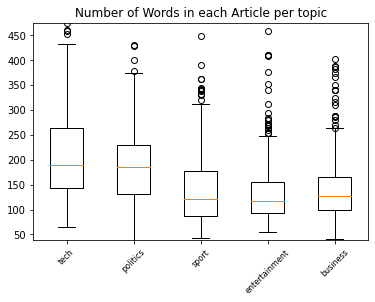

,tech,politics,sport,entertainment,business
count,401.000000,417.000000,510.000000,386.00000,510.00000
mean,213.880299,195.738609,143.194118,144.07772,139.94902
std,111.675336,139.855957,80.966871,124.31821,59.48480
min,65.000000,38.000000,42.000000,54.00000,40.00000
25%,144.000000,132.000000,87.000000,93.25000,99.00000
50%,189.000000,186.000000,122.000000,117.00000,127.00000
75%,264.000000,230.000000,178.500000,154.75000,164.75000
max,1433.000000,2074.000000,659.000000,1708.00000,403.00000


In [13]:
# Number of Words in articles per topic (splitting on " ")
text_lens = get_text_length(summaries_df, " ")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in Word count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Words in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

Comparing the word counts to the sentance counts we can see the same outliar issue exists as well as sports having less words despite having more sentances implying that sentance length will vary based on the topic.

### Next looking at the ground truth reduction in word count

In [14]:
# Summary length reduction per topic by word count
articles_len = get_text_length(articles_df, " ")
summaries_len = get_text_length(summaries_df, " ")


# For each Topic
print("Average percent reduction in words for ...")
for i,topic in enumerate(articles_df['label'].unique()):
    # 1  - ratio of summary to article length
    avg_percent_reduction = np.mean(1-np.asarray(summaries_len[i])/np.asarray(articles_len[i]))
    print(f"{topic} summaries: {100*avg_percent_reduction:0.4f}%")

Average percent reduction in words for ...
tech summaries: 57.2868%
politics summaries: 56.5632%
sport summaries: 55.5133%
entertainment summaries: 56.0781%
business summaries: 56.8027%


From this we see across the board roughly half of the words are dropped in the ground truth summaries implying our model should have a similar dropout rate. This also may indicate classification may be a valid approach to determining whether a sentance should remain in the summary. Running this code over with sentance count reveals a similar trend implying no relationship between sentance length and likelyhood to be in the summmary.

### EDA with common heuristics in NLP

In extractive text summarization a common baseline model is to simply take the first few sentances (typically 3) of a peice of text as the summary as writers often introduce their main points in the beggining of articles. We will analyze the effectiveness of this heuristic for the BBC model for possible consideration for a baseline model

In [19]:
# For regular expression
import re
# for sentance parsing
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# turn each article into a list of sentances
def get_sentences(texts_list):
    documents = []
    for text in texts_list:
        documents.append(sent_tokenize(text.replace("\n\n",". ").replace(".. ",". ").replace(".",". ").replace(".  ",". ")))
    return documents
    #return [[a.strip() for a in t.replace("\n\n",".").split(".") if a!=''] for t in texts_list]

# First sentance inclusion in summary
article_sentances = get_sentences(articles_df["text"])
summary_sentances = get_sentences(summaries_df["text"])

# Check how many sentances (up to the fourth) of the article are in the summary
counts = [0]*4
for a,s in zip(article_sentances,summary_sentances):
    for i in range(len(counts)):
        if a[i+1] in s:
            counts[i]+=1
        else:
            break
print(f"{100*counts[0]/len(article_sentances):0.2f}% Article summaries include the first sentance of the article")
print(f"{100*counts[1]/len(article_sentances):0.2f}% Article summaries include the first and second")
print(f"{100*counts[2]/len(article_sentances):0.2f}% Article summaries include the first, second, and third")
print(f"{100*counts[3]/len(article_sentances):0.2f}% Article summaries include the first, second, third and fourth")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


69.83% Article summaries include the first sentance of the article
36.29% Article summaries include the first and second
17.81% Article summaries include the first, second, and third
7.33% Article summaries include the first, second, third and fourth


From this a good baseline model to compare text summarization would simply be to use the first few sentances of each article as the summary. The performance of this method is best with including one to two sentances

## Metrics

In [17]:
!pip install rouge
from rouge import Rouge
def rouge_metric_calculator (model_output_summary, correct_summary):
  rouge = Rouge()
  score = rouge.get_scores(model_output_summary, correct_summary)
  return score

def calculate_metric(model_output_summary, prediction_array):
  i=0
  running_one_r = 0
  running_one_p = 0
  running_one_f = 0
  running_two_r = 0
  running_two_p = 0
  running_two_f = 0
  for model_output in prediction_array:
    #print(model_output[0])
    correct_summary = summaries_df["text"][i]
    #print(correct_summary)
    rouge_metric = rouge_metric_calculator (model_output[0], correct_summary)
    #print(rouge_metric)
    one = rouge_metric[0]['rouge-1']
    one_r = one['r']
    #print("one_r", one_r)
    running_one_r += one_r
    one_p = one['p']
    running_one_p += one_p
    one_f = one['f']
    running_one_f += one_f
    i = 1+i
  average_rouge_running_one_r = running_one_r/i
  average_rouge_running_one_p = running_one_p/i
  average_rouge_running_one_f = running_one_f/i
  print("Average Rouge-1 Recall", average_rouge_running_one_r)
  print("Average Rouge-1 Precision", average_rouge_running_one_p)
  print("Average Rouge-1 F1", average_rouge_running_one_f)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Base Line Model
From the EDA we found that an effective baseline model would be taking the first two sentances of the article as the predicted summary

In [20]:
# Each base line prediction is the first two sentaces of the article
def base_line_predict(articles_df):
    predictions = []
    article_sentances = get_sentences(articles_df["text"])
    for a in article_sentances:
        predictions.append(a[1:3])
    return predictions

pred = base_line_predict(articles_df)
print(f"Example baseline: {pred[0]}\n")
print(f"Example summary: {summary_sentances[0]}")

Example baseline: ['Re-using old mobile phones is not just good for the environment, it has social benefits too.', 'Research has found that in some developing nations old mobile phones can help close the digital divide.']

Example summary: ["Mr Goodman said phone operators and consumers needed to do more to ensure that more of Britain's mobile mountain made it overseas.", '"This is the only way I can afford to have a phone," she said.', 'Older mobile phones are proving particularly useful in poorer nations where people want to use a mobile and keep in touch with friends and family but do not have the income to buy the most up to date model.', 'Re-using old mobile phones is not just good for the environment, it has social benefits too.', 'Reconditioned handsets have boosted take-up of mobiles as the report revealed that almost one-third of Romanian pre-pay mobile phone users were using reconditioned handsets.', '"It\'s quite common for people to have two or three phones just lying aroun

In [21]:
prediction_array = pred
model_output_summary = summary_sentances
calculate_metric(model_output_summary, pred)

Average Rouge-1 Recall 0.16760817559295432
Average Rouge-1 Precision 0.8384134137026963
Average Rouge-1 F1 0.2726681834613348


## Preprocessing For Extractive Text Summarization

In [22]:
from nltk.tokenize import word_tokenize
def compare_sentances(sentance_a, sentance_b):
    tok_a = word_tokenize(sentance_a)
    tok_b = word_tokenize(sentance_b)
    matches = 0
    for tok in tok_a:
        if tok in tok_b:
            matches+=1
    return float(matches)/len(tok_a)
    
# Generate Label
def generate_labels(articles_df, summaries_df):
    article_sentances = get_sentances(articles_df["text"])
    summary_sentances = get_sentances(summaries_df["text"])
    labels = []
    count=0
    total_sentances = 0
    same = 0
    for article,summary in zip(article_sentances,summary_sentances):
        sentance_inclusion = []
        for sentance_a in article:
            in_summary = False
            for sentance_b in summary:
                if len(sentance_b)<3:
                    continue
                percent_match = compare_sentances(sentance_a, sentance_b)
                if percent_match > 0.95:
                    in_summary=True
                    break
            total_sentances+=1
            if in_summary and len(sentance_a)>3:
                sentance_inclusion.append(1)
            else:
                sentance_inclusion.append(0)
        same+=np.sum(sentance_inclusion) == len(summary)
        count+=1
        print(f"Percent Complete: {100*count/len(article_sentances):0.2f}%",end="\r")
        labels.append(sentance_inclusion)
        
    print()
    print("Matching  labels ",same)
    print("Total ",len(article_sentances))
    print(f"Total Sentances processed {total_sentances}")
    return labels

## Extractive Text Summarization (Non-Deep Learning)

In [23]:
!pip install networkx==2.6.3
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.1 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [24]:
import shutil
import nltk 
nltk.download('stopwords')

from math import sqrt

from nltk.corpus import stopwords
from xml.dom.minidom import parse
    
def readDocument(contents):
    sentences = list()

    contents = contents.split('.')
   
    for sentence in contents:
        # Refine sentence and replace sentences that begin with non-alpha characters
        refinedSentence = sentence.replace("[^a-zA-Z]", " ").split(" ")
        # Add refined sentence to list of sentences
        sentences.append(refinedSentence)
    sentences.pop()

    # Filter out sentences that contain only two or less words
    sentences = list(filter(lambda x: len(x) > 2, sentences))

    return sentences                

# Calculate the cosine distance between two lists
def cosSimilarity(l1, l2):
    # Follows the formula for cosine distance 1 - (u.v / |u||v|)
    return 1 - (np.dot(l1, l2) / (sqrt(np.dot(l1, l1)) * sqrt(np.dot(l2, l2))))


def sentenceSimilarity(s1, s2, stopwords=None):
    if stopwords is None: stopwords = list()

    s1 = [t.lower() for t in s1]
    s2 = [t.lower() for t in s2]

    # Combined set of words from both sentences
    words = list(set(s1 + s2))

    wordsLength = len(words)

    # Initialize vectors for both setences
    l1 = [0] * wordsLength
    l2 = [0] * wordsLength

    # Create vector for the first sentence
    for w in s1:
        if w in stopwords: continue
        l1[words.index(w)] += 1

    # Create the vector for the second sentence
    for w in s2:
        if w in stopwords: continue
        l2[words.index(w)] += 1

    return 1 - cosSimilarity(l1, l2)


def createSimilarityMatrix(sentences, stop_words):
    # Create an empty similarity matrix
    sentenceLength = len(sentences)
    similarityMatrix = np.zeros((sentenceLength, sentenceLength))

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i == j:  continue # ignore if both are same sentences 
            similarityMatrix[i][j] = sentenceSimilarity(sentences[i], sentences[j], stop_words)

    return similarityMatrix


# Summarize the given document
def summarize(text, num_sentences):
    stopWords = stopwords.words('english')
    topSentences = list()

    sentences = readDocument(text)

    # Create a similarity matrix in regards to all of the sentences in the document
    similarityMartix = createSimilarityMatrix(sentences, stopWords)

    # Rank sentences in similarity martix
    similarityGraph = nx.from_numpy_array(similarityMartix)
    scores = nx.pagerank(similarityGraph, max_iter=100)
    
    # Sort by sentance rank
    rankedSentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    for i in range(min(num_sentences, len(rankedSentences))): topSentences.append(" ".join(rankedSentences[i][1]))

    ret = "Text Summmary: \n", ". ".join(topSentences) + '.\n\n'
    return ret


# Get summaries of the documents in the dataset
prediction_array = list()
def getSummaries(n):
  i = 0
  for text in articles_df["text"]:
    prediction_array.append(summarize(text, 30))
    # i += 1
    # if i == n: break
  return prediction_array


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
getSummaries(1)

In [26]:
calculate_metric(model_output_summary, prediction_array)

Average Rouge-1 Recall 8.175277959450621e-06
Average Rouge-1 Precision 0.0004496402877697842
Average Rouge-1 F1 1.60585813906273e-05


## Extractive model (based on single sentence analysis)

In [27]:
article_sentances = get_sentences(articles_df["text"])
y_labels = generate_labels(articles_df, summaries_df) 

Percent Complete: 100.00%
Matching  labels  1867
Total  2224
Total Sentances processed 46905


In [28]:
import tensorflow as tf
#from tensorflow_models import nlp
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.utils import pad_sequences
import string 

def ex_standarize(input_txt):
  lowercase_txt = tf.strings.lower(input_txt)
  return tf.strings.regex_replace(lowercase_txt,'[%s]' % re.escape(string.punctuation),'')

max_features = 1000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=ex_standarize,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


vectorize_layer.adapt(articles_df["text"])

all_sentances = []
all_labels = []

for i in range(len(article_sentances)):
    for j in range(len(article_sentances[i])):
        all_sentances.append(article_sentances[i][j])
        all_labels.append(y_labels[i][j])

x_train = vectorize_layer(all_sentances)
y_train = np.asarray(all_labels)
print(f"There are {len(x_train)} sentances in total")
print(f"Vecorized sentance sample: {x_train[1][:10]}")
print(f"Corresponding label: {y_train[1]}")

There are 46905 sentances in total
Vecorized sentance sample: [  1 683 170 434   9  27  81 123   8   2]
Corresponding label: 1


In [29]:
embedding_dim = 32
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(128, 7, padding="valid", activation="relu", strides=2),
  layers.Conv1D(128, 7, padding="valid", activation="relu", strides=2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32032     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         28800     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [30]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [31]:
from sklearn.model_selection import train_test_split
# 80 10 10 split for training validation test
X_train, X_test, Y_train, Y_test = train_test_split(x_train.numpy(), y_train, test_size=0.2,shuffle=True,random_state=41)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=41)

epochs = 20
print(x_train.shape)
history = model.fit(x_train,y_train, validation_data=(X_valid, Y_valid),epochs=epochs,batch_size =32)


(46905, 250)
Epoch 1/20
1466/1466 [==============================] - 19s 7ms/step - loss: 0.6210 - binary_accuracy: 0.6556 - val_loss: 0.6087 - val_binary_accuracy: 0.6800
Epoch 2/20
1466/1466 [==============================] - 8s 5ms/step - loss: 0.5937 - binary_accuracy: 0.6828 - val_loss: 0.5764 - val_binary_accuracy: 0.6942
Epoch 3/20
1466/1466 [==============================] - 8s 6ms/step - loss: 0.5803 - binary_accuracy: 0.6906 - val_loss: 0.5569 - val_binary_accuracy: 0.7128
Epoch 4/20
1466/1466 [==============================] - 8s 5ms/step - loss: 0.5661 - binary_accuracy: 0.7023 - val_loss: 0.5388 - val_binary_accuracy: 0.7188
Epoch 5/20
1466/1466 [==============================] - 9s 6ms/step - loss: 0.5510 - binary_accuracy: 0.7125 - val_loss: 0.5205 - val_binary_accuracy: 0.7345
Epoch 6/20
1466/1466 [==============================] - 8s 6ms/step - loss: 0.5336 - binary_accuracy: 0.7260 - val_loss: 0.4998 - val_binary_accuracy: 0.7520
Epoch 7/20
1466/1466 [================

In [32]:
print(history.history)

{'loss': [0.620954692363739, 0.5936546921730042, 0.5802894234657288, 0.5660550594329834, 0.551008939743042, 0.5335965752601624, 0.5167625546455383, 0.49958401918411255, 0.48391246795654297, 0.467792809009552, 0.4534926414489746, 0.43729716539382935, 0.42501282691955566, 0.40941643714904785, 0.39914408326148987, 0.3812743127346039, 0.36967799067497253, 0.3587146997451782, 0.3449938893318176, 0.33265799283981323], 'binary_accuracy': [0.6556017398834229, 0.6827630400657654, 0.6906300187110901, 0.7023345232009888, 0.7125466465950012, 0.7260206937789917, 0.7366165518760681, 0.7482144832611084, 0.7596844434738159, 0.7682549953460693, 0.7784671187400818, 0.7884660363197327, 0.7961198091506958, 0.8046690225601196, 0.8135380148887634, 0.8232597708702087, 0.8279927372932434, 0.8359023332595825, 0.8432363271713257, 0.8509753942489624], 'val_loss': [0.608669102191925, 0.5763833522796631, 0.5569223761558533, 0.5388485789299011, 0.5204702019691467, 0.49977970123291016, 0.47453561425209045, 0.4539355

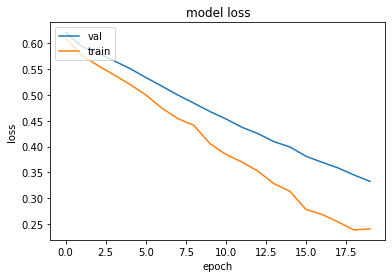

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

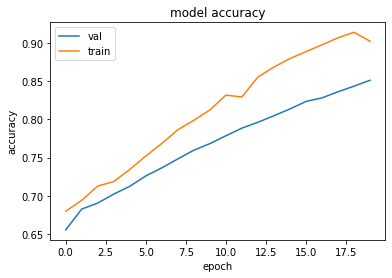

In [34]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val','train',], loc='upper left')
plt.show()

In [35]:
# reconstruct summaries
# All predicted summaries is a list for each article where each entry is a list of summary sentances
all_predicted_summaries = []
for i in range(len(article_sentances)):
    model_predictions = model.predict(vectorize_layer(article_sentances[i]),verbose = 0)
    model_predictions = np.where(model_predictions>0.5,1,0)
    summary = []
    for j in range(len(article_sentances[i])):
        if model_predictions[j]==1:
            summary.append(article_sentances[i][j])
    all_predicted_summaries.append(summary)
    print(f"Percentage Complete: {100*i/len(article_sentances):0.2f}%",end="\r")
print()

Percentage Complete: 99.96%


In [36]:
print(all_predicted_summaries[400])
out = ""
for s in all_predicted_summaries[400]:
    out+=s
print(out)
print(summaries_df["text"][400])

['The mobile gaming industry is set to explode in 2005 with a number of high-profile devices offering a range of gaming and other features such as movie and music playback.', 'Market leader Nintendo, however, is releasing a handheld console that it says will revolutionise the way games are played.', 'Nintendo has given developers free rein to utilise the dual screens and ability to control the action by simply touching the screen.', 'Nintendo first launched its GameBoy console in 1989 and has dominated the market ever since.', 'With its two screens, wireless connectivity and backwards compatibility with the GameBoy Advance, the DS certainly has a number of unique selling points.', 'With more than two million pre-orders for the device in Japan, Nintendo is confident it will keep its number one spot.', 'Super Mario 64 DS is a faithful re-creation of the Nintendo 64 classic with a host of new mini-games and new levels.', 'The game looks stunning on the portable machine and the sound too i

In [37]:
prediction_array = [''.join(map(str, sub_list)) for sub_list in all_predicted_summaries]
calculate_metric(model_output_summary, prediction_array)

IndexError: ignored

## Preprocessing For Abstractive Text Summarization

In [ ]:
# Import tokenizer from pretrained model
from transformers import AutoTokenizer, TFAutoModelWithLMHead, AutoModelForSeq2SeqLM

model_name = "t5-small"

model = TFAutoModelWithLMHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_tf_auto.py:608: FutureWarning: The class `TFAutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `TFAutoModelForCausalLM` for causal language models, `TFAutoModelForMaskedLM` for masked language models and `TFAutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

RuntimeError: ignored

In [ ]:
def abstract_tokenize(tokenizer, input_data):
  inputs = []

  for i in range(input_data.shape[0]):
    inputs.append(tokenizer.encode("summarize: " + input_data["text"][i], # required prefix
                              return_tensors = "tf",
                              max_length = 512, # required max_length
                              truncation = True))

  # readout
  print("Tokenized", len(inputs), "entries")
  print()
  print("Sample tokenized input:")
  print(inputs[0])

  return inputs

In [ ]:
tokenized_array = abstract_tokenize(tokenizer, articles_df)

## Abstractive Text Summarization (with T5-Small)

In [ ]:
def abstract_summarize(model, tokenized_input):
  outputs = []

  for i in range(len(tokenized_input)):
    outputs.append(model.generate(tokenized_input[i],
                            max_length=200,
                            min_length=30,
                            length_penalty=2.0,
                            num_beams=2,
                            early_stopping=True,
                            no_repeat_ngram_size=3))

  # readout
  print("Summarized", len(outputs), "entries")

  return outputs

In [ ]:
def abstract_prediction(tokenizer, summarized_input):
  prediction = []

  for i in range(len(summarized_input)):
    prediction.append([tokenizer.decode(token,
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=True)
                                  for token in summarized_input[i]])

  # readout
  print("Decoded", len(prediction), "predicted summaries")

  print()
  print("Sample article:")
  print(summaries_df["text"][0])

  print()
  print("Sample prediction:")
  print(prediction[0][0])

  return prediction

In [ ]:
summarized_array = abstract_summarize(model, tokenized_array[:5])

In [ ]:
prediction_array = abstract_prediction(tokenizer, summarized_array)

In [ ]:
calculate_metric(model_output_summary, prediction_array)